### <strong>第二次作品：SVD 與影像特徵實驗</strong>
學號：711233112

姓名：留筠雅
<hr>

 <font color=skyblue>作品目標</font>：  

在影像處理中，奇異值分解 (SVD) 常被用來進行圖像壓縮、特徵提取等操作。透過完成本次實作，將理解到：
 1. 奇異值分解 (SVD) 的基本概念和原理。
 2. 學會做 Rank q approximation 和分割重組圖片。
 3. 學會使用蒙太奇函數表達多張影像。
 4. 學會圖像的加密與解密，並實際用圖片完成操作。

<hr>

#### **第 1 題：**

#### **將一張圖像 $X$ 利用 SVD 的 "Rank q approximation"，能達到壓縮的目的並保持圖像的品質。比較下列幾種對於圖像矩陣 $X$ 的重組安排，並進行 "Rank q approximation"，在同樣的壓縮比之下，觀察還原後的圖像品質哪個最好？能說出理由嗎？**
圖片來源：[USC-SIPI](<https://sipi.usc.edu/database/database.php?volume=misc&image=1#top>)

1. X 不變

1. 將 X 以 8 $\times$ 8 小圖（patch）進行切割，再將每個小圖拉成 64 $\times$ 1 的向量，最後重組這些向量並排成新的 64 $\times$ N 矩陣。

1. 同上，小圖大小為 16 $\times$ 16/per patch。

1. 同上，但分割成 32 $\times$ 32/per patch。


如何呈現最後的比較結果，請自行決定，譬如，將圖像並列比較。圖像可以選 Lenna， 也可以自行決定。影像不同也可能導致結果不同。

(1) X 不變

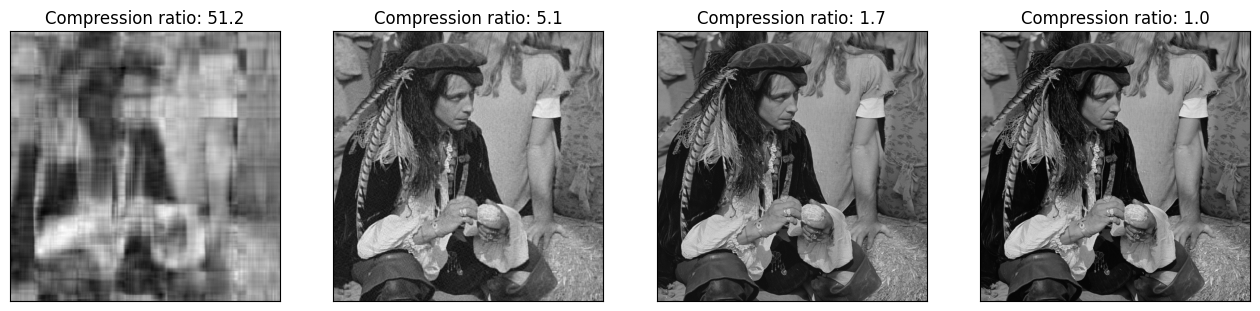

In [2]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgfile = '5.3.01.tiff'  # 1024x1024
X = mpimg.imread(imgfile) 
if len(X.shape) > 2:
    X  = np.mean(X, axis=2) # convert RGB to grayscale
#plt.imshow(X, cmap = 'gray')
#plt.show()


N, p = X.shape
U, E, VT = svd(X, full_matrices = False)
q = np.array([10,100,300,512], dtype=int) #取幾個主成分

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, r in enumerate(q):
    Xq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :]
    ax[i].imshow(Xq, cmap = 'gray')
    ratio = N * p / (U.shape[0] + VT.shape[1]) / r
    ax[i].set_title('Compression ratio: {:.1f}'.format(ratio))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()



**<font color=skyblue>對執行結果的觀察紀錄：</font>**  
- 隨著主成分（q）的減少，壓縮後圖片的品質會相應下降。當主成分個數為 1024 時，即保持完整的秩（full rank），壓縮後的圖片品質最佳、最清晰。

(2) 將 X 以 8 $\times$ 8 小圖（patch）進行切割，再將每個小圖拉成 64 $\times$ 1 的向量，最後重組這些向量並排成新的 64 $\times$ N 矩陣。

(3) 同上，小圖大小為 16 $\times$ 16/per patch。

(4) 同上，但分割成 32 $\times$ 32/per patch。

首先寫一個函數用來將切割的向量重組。

In [3]:
import numpy as np

def montage(A, m, n):
    '''
    Create a montage matrix with mn images
    Inputs:
    A: original pxN image matrix with N images (p pixels), N > mn
    m, n: m rows & n columns, total mn images
    Output:
    M: montage matrix containing mn images  
    '''

    sz = np.sqrt(A.shape[0]).astype('int') # image size sz x sz
    M = np.zeros((m*sz, n*sz)) # montage image
    for i in range(m) :
        for j in range(n) :
            M[i*sz: (i+1)*sz, j*sz:(j+1)*sz] = \
            A[:, i*n+j].reshape(sz, sz)
    return M

將圖像切割小區域，做 Rank q approximation ，並重組。

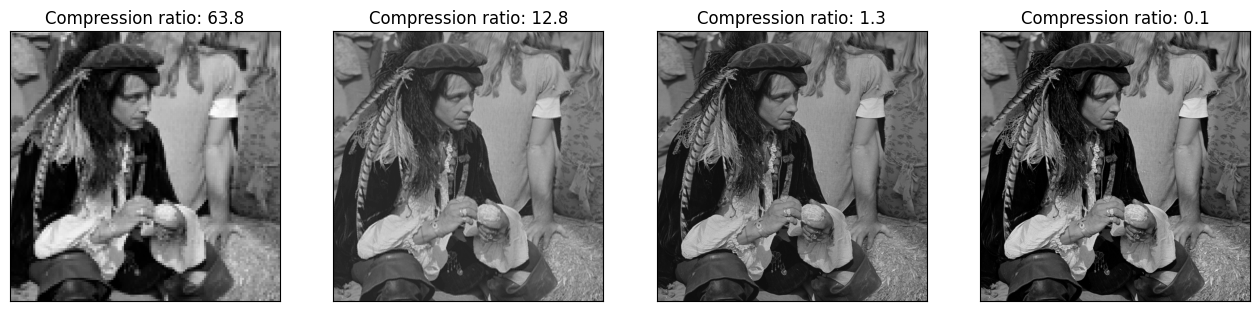

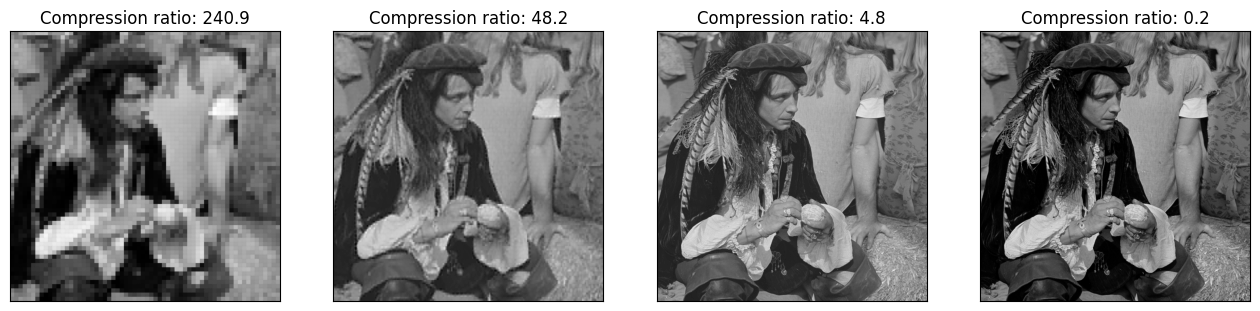

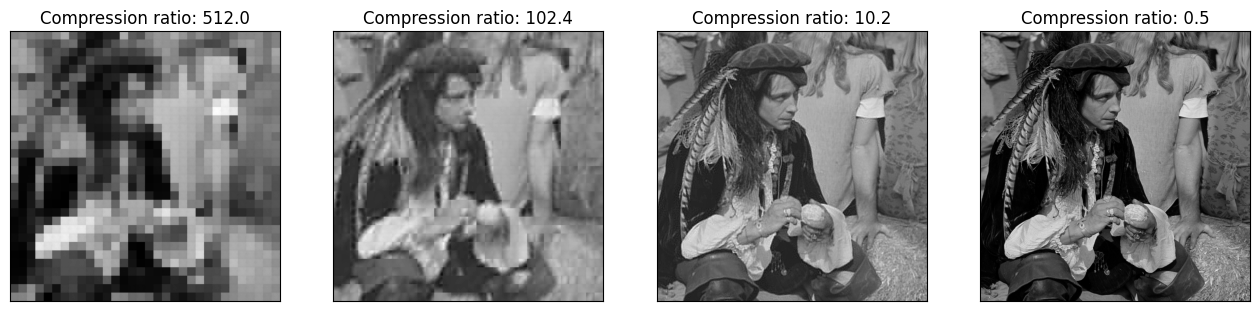

In [4]:
import skimage.util as skutil
from numpy.linalg import svd
import matplotlib.pyplot as plt
def patching(X, patch_sz):
        
    # 將圖像切割小區域
    p, N = X.shape # p by N, p = 1024, N = 1024
   
    p_patch = patch_sz ** 2 
    N_patch = int(N * p / p_patch)
    patches = skutil.view_as_windows(X, (patch_sz, patch_sz), \
                                    step=patch_sz)

    M = np.empty((patch_sz*patch_sz, 0))  # initialize M as an empty array with shape (patch_sz*patch_sz,0)
    # 將每張小圖轉換成（reshape）64 × 1 的向量，再由左而右組合成一64 × 16384 的新矩陣。
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j].reshape(-1, 1)
            M = np.append(M, patch, axis=1)  # append the reshaped patch to M

    # 對新矩陣M做 Rank q approximation 
    U, E, VT = svd(M, full_matrices = False)
    q = np.array([1,5,50,1024], dtype=int) #取幾個主成分

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    # 將近似矩陣的每一列重組回 8 x 8 的小圖，並依序組合回原圖的結構
    for i, r in enumerate(q):
        Mq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :] 
        ax[i].imshow(montage(Mq, int(p/patch_sz), int(p/patch_sz)), cmap = 'gray')
        ratio = N * p / (U.shape[0] + VT.shape[1]) / r
        ax[i].set_title('Compression ratio: {:.1f}'.format(ratio))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.show()
patching(X, 8)
patching(X, 16)
patching(X, 32)

**<font color=skyblue>對執行結果的觀察紀錄：</font>**  
- 由上述的執行成果可知，切割區域大小越小，圖片壓縮過後的品質越好。
- 當主成分 q 取得越小，壓縮後的品質越差，這是因為所保留的重要資訊越少，導致損失的資料越多。

#### **習題 2：**
#### **處理大量影像前，有必要觀看影像圖，以確定能掌握將要處理的影像及其資料型態。以 70000 張手寫圖像為例，每個數字約 7000 字，需要寫一段程式碼來觀察這些手寫數字的影像與品質，且每次執行都能隨機觀看到不同的影像，如下圖左（共兩排含 0~9 的數字各 50 個）與圖右的影像是兩次執行的結果。請靜下心來仔細寫這段程式碼，可以按下圖的方式呈現，或用自己的方式都歡迎。類似像這樣的程式基本功事非常重要且必要的。**

請注意：隨機從某個數字抽取一定數量的影像，可以採「取後不放回」的方式，譬如 np.random.choice(np.arange(N), replace=False, size=n) 從 0 ~ N 的整數中隨機取 n 個

下載手寫數字圖像檔案：

In [5]:
import pickle
import os
from sklearn.datasets import fetch_openml
import numpy as np

data_file = "digits.pkl"
#check if data file exists
if os.path.exists(data_file):
    #load data from file
    with open(data_file, "rb") as f:
        data = pickle.load(f)
else:
    #load data from internet
    data = fetch_openml('mnist_784', version=1, parser="auto")
    #save data to file
    with open(data_file, "wb") as f:
        pickle.dump(data, f)

X, y = np.array(data.data).T, np.array(data.target).astype("int")

用 montage() 函數把資料呈現在一張圖片上。

In [6]:
import numpy as np

def montage(A, m, n):
    '''
    Create a montage matrix with mn images
    Inputs:
    A: original pxN image matrix with N images (p pixels), N > mn
    m, n: m rows & n columns, total mn images
    Output:
    M: montage matrix containing mn images  
    '''

    sz = np.sqrt(A.shape[0]).astype('int') # image size sz x sz
    M = np.zeros((m*sz, n*sz)) # montage image
    for i in range(m) :
        for j in range(n) :
            M[i*sz: (i+1)*sz, j*sz:(j+1)*sz] = \
            A[:, i*n+j].reshape(sz, sz)
    return M

先以數字 3 為例，寫出隨機抽出 50 個只有數字 3 的部分。

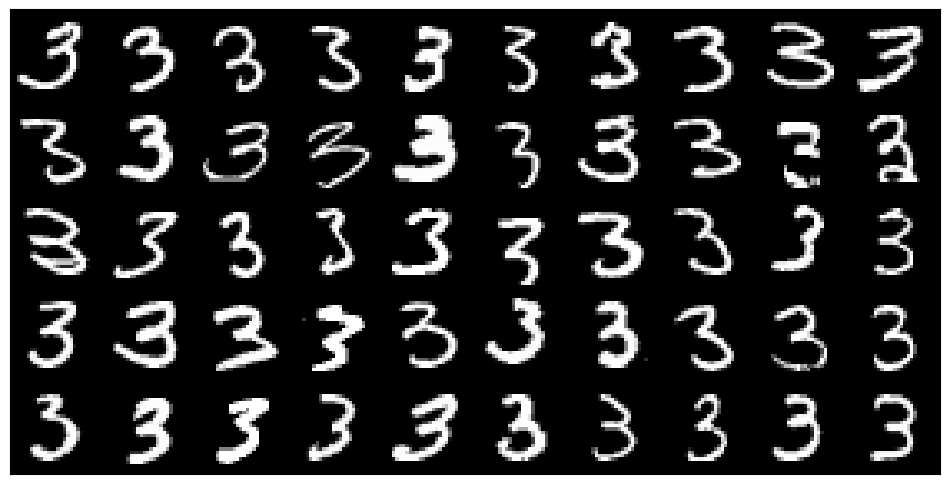

In [7]:
digit_to_show = 3 
N= len(y[y==digit_to_show])#有7141個3
m, n = 10, 5 # m x n montage (total mn images) 
size = m*n
a = np.random.choice(np.arange(N), replace=False, size=size)

Digit = X[:, y == digit_to_show]#784x7141
plt.figure(figsize = (12, 12))
M = montage(np.array(Digit[:,a]), n, m)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest') 
plt.xticks([])
plt.yticks([])
plt.show()



展現 0~9 的數字部分， 每個數字分別抽 50 個畫圖呈現。

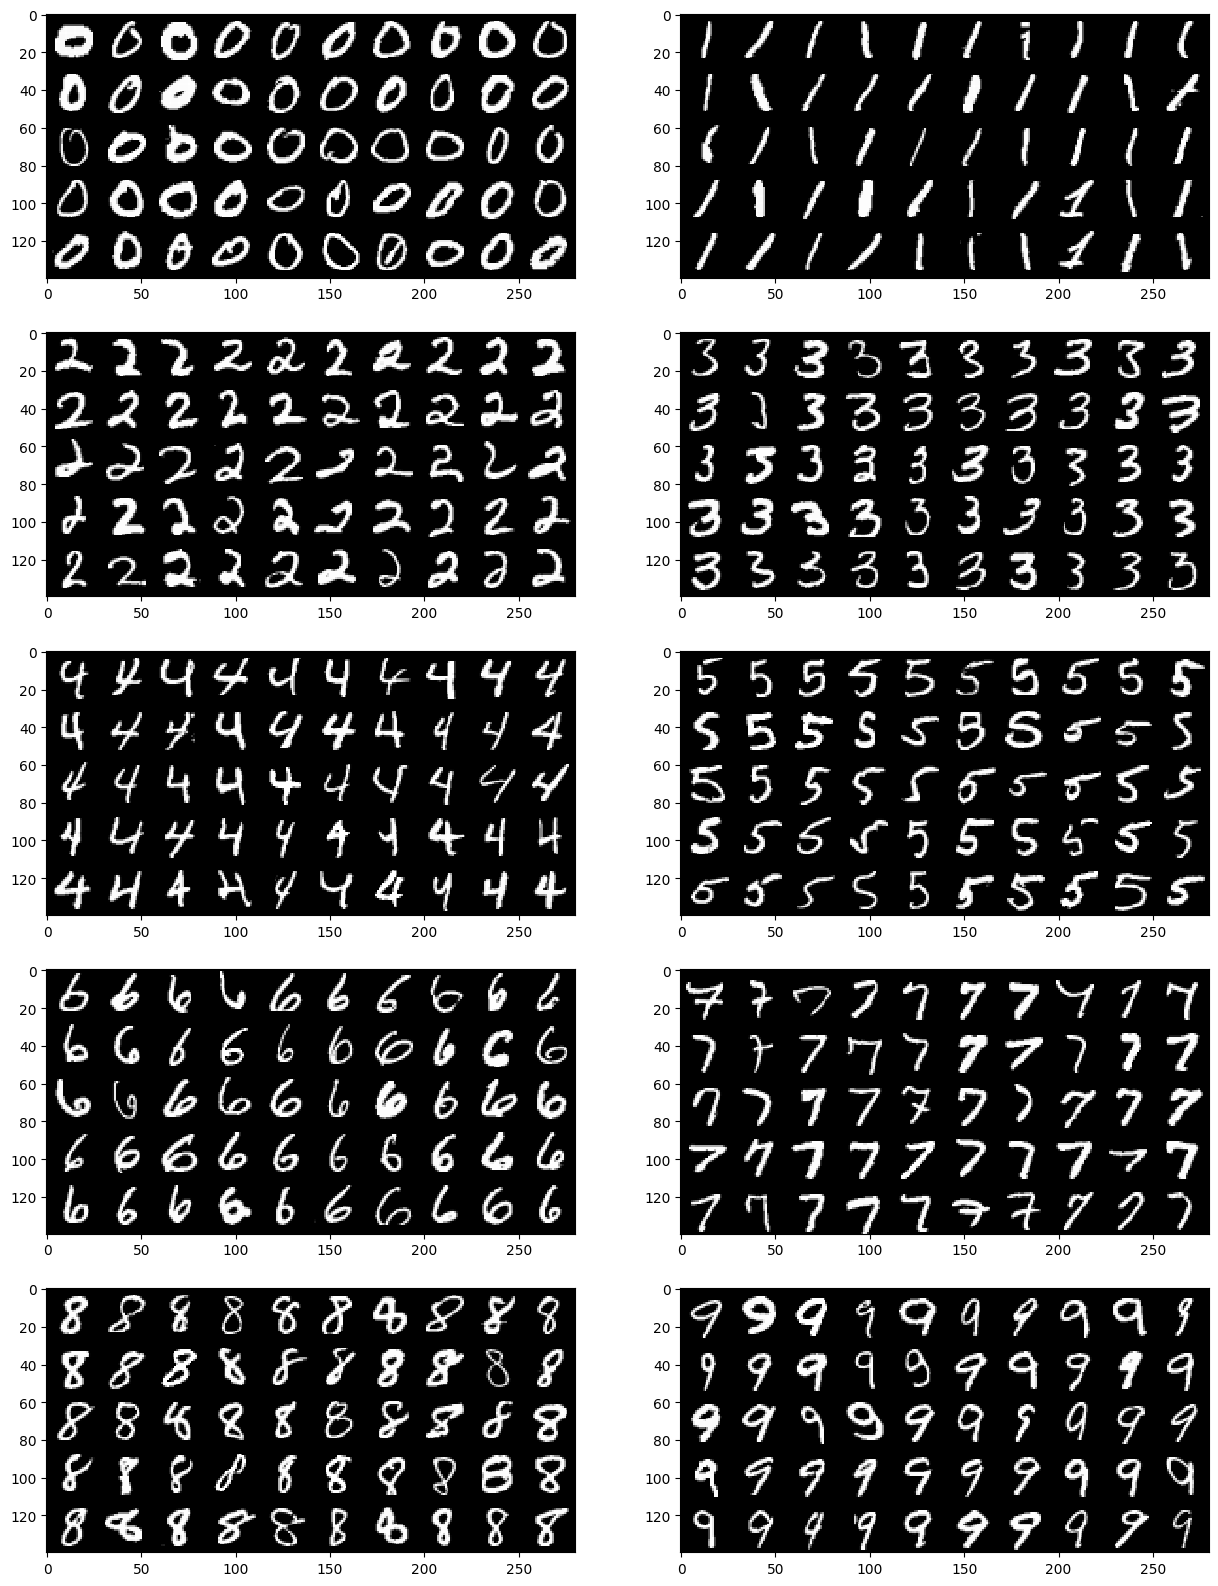

In [8]:
digit_to_show =np.arange(10)
fig = plt.figure(figsize=(15, 20)) 
for i,r in enumerate(digit_to_show):
    N= len(y[y==digit_to_show[r]])
    m, n=10,5 #Amxnmontage(totalmnimages)
    size = m*n
    a=np.random.choice(np.arange(N), replace=False, size=size)
    Digit = X[:, y == digit_to_show[r]]
    plt.subplot(5,2,i+1)
    M = montage(np.array(Digit[:,a]), n, m)
    plt.imshow(M, cmap = 'gray', interpolation = 'nearest') 
plt.show()

進行兩次抽樣以驗證為隨機抽樣。

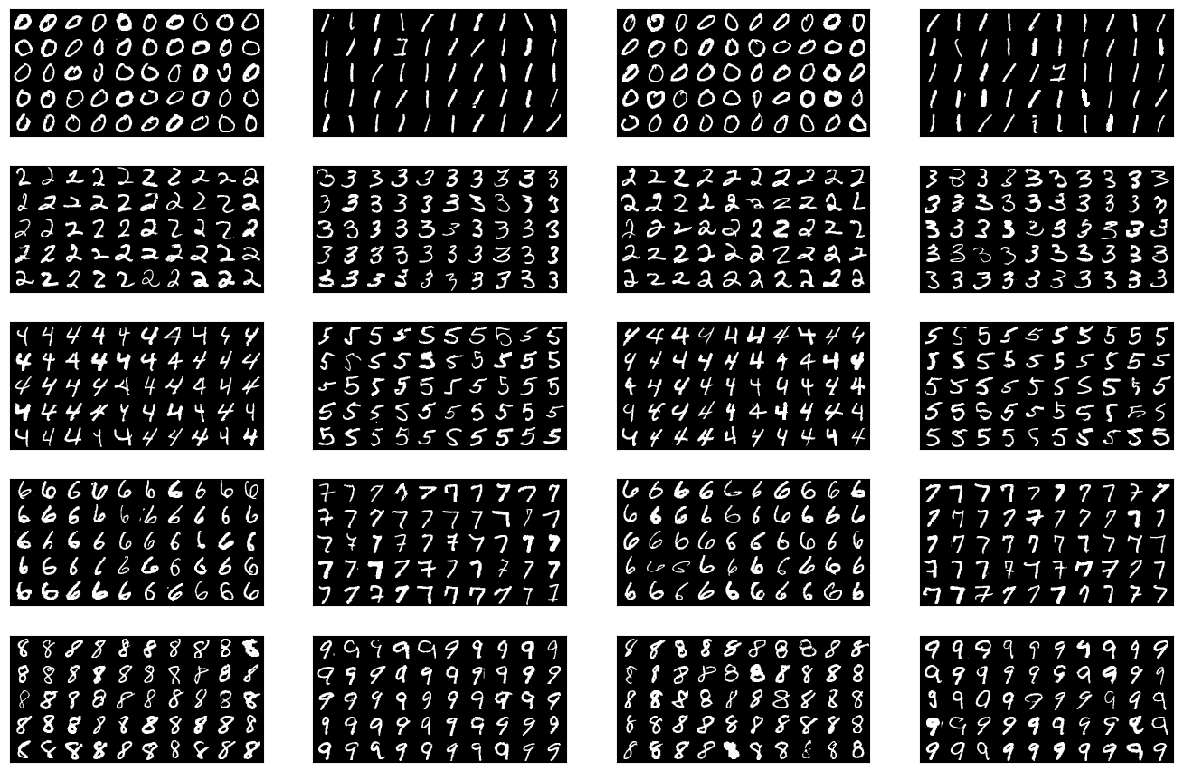

In [9]:
digit_to_show =np.array([0,1,0,1,2,3,2,3,4,5,4,5,6,7,6,7,8,9,8,9])
fig = plt.figure(figsize=(15, 20)) 
for i, r in enumerate(digit_to_show):
    N = len(y[y==r])
    m, n=10,5 #Amxnmontage(totalmnimages)
    size = m*n
    a=np.random.choice(np.arange(N), replace=False, size=size)
    Digit = X[:, y == r]
    plt.subplot(10,4 ,i+1)
    M = montage(np.array(Digit[:,a]), n, m)
    plt.imshow(M, cmap = 'gray', interpolation = 'nearest') 
    plt.xticks([])
    plt.yticks([])
plt.show()

**<font color=skyblue>對執行結果的觀察紀錄：</font>**  
- 由上述的圖片可知，抽樣結果並不一致，符合隨機抽樣。


#### **習題 3：**
#### **每張大小 28×28 的手寫數字圖像 70000 張，不經壓縮前的儲存空間為 54.88 M Bytes。若進行 SVD 的 "Rank q approximation"，則壓縮倍數由 $q$ 決定。寫一支程式，當調整 $q$ 值時，可以算出壓縮的倍數，並同時顯示原圖與壓縮後還原的圖各 100 張做為比較（任選 100 張）。另外 $q$ 的選擇可以根據 $\sigma_1$ , $\sigma_2$, $\cdots$ ,  $\sigma_r$ 的「能量配置」來決定，或說決定 $q$ 之後，可以計算所採用的主成分的能量佔比，本題也可以順便列印出這個佔比。**

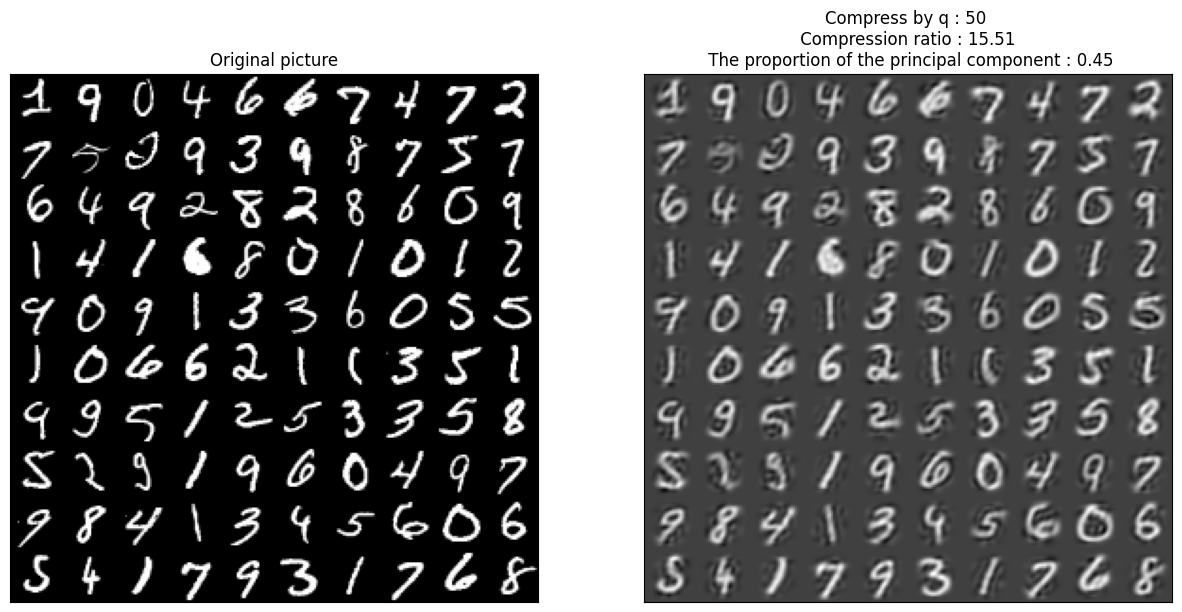

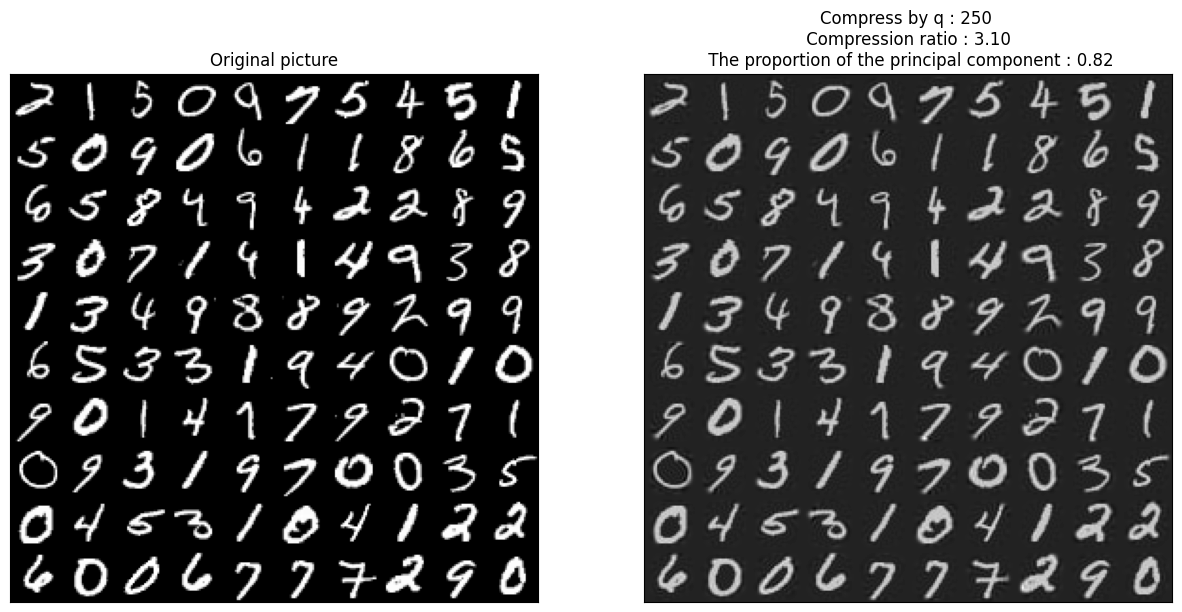

In [10]:
def svd_ratio(A,q):
    '''
    A: the image
    q: the number of components
    '''
    imgsize = A.shape[0]*A.shape[1] # N*p
    pcasize = q*A.shape[0] # N*q
    compresssize = q*A.shape[1] # q*p
    ratio = imgsize / (pcasize+compresssize) 
   
    
    fig,ax=plt.subplots(1,2,figsize=(15,15))
    N, p = A.shape
    a = np.random.choice(np.arange(N), replace=False, size=100)
    M=montage(np.array(X[:,a]),10,10)
    ax[0].imshow(M,cmap='gray')
    ax[0].set_title('Original picture')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ########
    U,E,VT=svd(A,full_matrices=False)
    Xq=U[:,:q]@np.diag(E[:q])@VT[:q,:]

    compratio=np.sum(np.diag(E[:q]))/np.sum(np.diag(E[:]))

    ax[1].imshow(montage(np.array(Xq[:, a]),10,10),cmap='gray')
    ax[1].set_title('Compress by q : {} \n Compression ratio : {:.2f} \n The proportion of the principal component : {:.2f}'.format(q,ratio,compratio))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.show()

svd_ratio(X,50)
svd_ratio(X,250)

**<font color=skyblue>對執行結果的觀察紀錄：</font>**  
- 由上述的執行成果可知，q 取越大，壓縮比會較小，主成分的能量佔比較大，因此圖片品質較好。
- 相反的是 q 取越小，壓縮比會較大，主成分的能量佔比較小，優點是有較少的儲存空間。
- 所謂的 SVD 就是希望透過 $\;q<<<<p$ 來達到降維的目的性。

#### **習題 4：**
#### **有 5 張經過加密的影像圖[（2024年版壓縮檔下載）](<https://ntpuccw.files.wordpress.com/2024/04/e4ba94e5bcb5e58aa0e5af86e79a84e5bdb1e5838f_2024.zip>)，其加密的方式採 Yale Faces 38 人 2410 張人臉圖像矩陣 $X$ 的 SVD，即 $X = U\Sigma V^T$，取 $U$ 作為影像加密的工具，即假設向量 $x$ 代表一張原圖影像，則 $U[:, 0:q]^T x$ 代表該影像的前 $q$ 個主成分，以此作為加密影像。請注意：這 5 張影像圖的主成分採 $q=2000$ ，矩陣 $X$ 先減去平均值，再執行 SVD 得到 $U$。**

(1) 請解密這 5 張影像。

從原始檔案可以發現這是一張加密的影像，如圖。

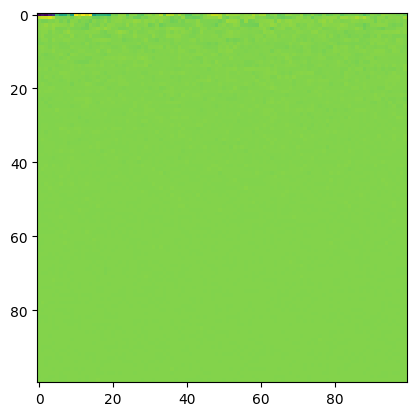

In [13]:
import pandas as pd

df = pd.read_csv('五張加密的影像_2024.csv')

img  =np.array(df.iloc[:, 0:5]) #Zq

plt.imshow(img.reshape(100,100))

載入Yale Faces 資料並做38個人的SVD分解。

In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.io
import pandas as pd
import matplotlib.image as mpimg

D = scipy.io.loadmat('allFaces.mat')
X = D['faces'] #32256*2410 each column represents an image 
y = np.ndarray.flatten(D['nfaces'])#分別代表每個人的張數
m = int(D['m'])#168
n = int(D['n'])#192
n_persons = int(D['person'])#38個人
avgFace = X.mean(axis = 1)
X_avg = X - avgFace.reshape(-1, 1)
U, E, VT = svd(X_avg, full_matrices=False)

C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\65272443.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(D['m'])#168
C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\65272443.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(D['n'])#192
C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\65272443.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_persons = int(D['person'])#38個人


 在加密的影像 $U[:, 0:q]^T x$ 前乘上 $U[:, 0:q]$ 當作解密的鑰匙。可成功在不知道 $x$ 的情況下解析圖片。

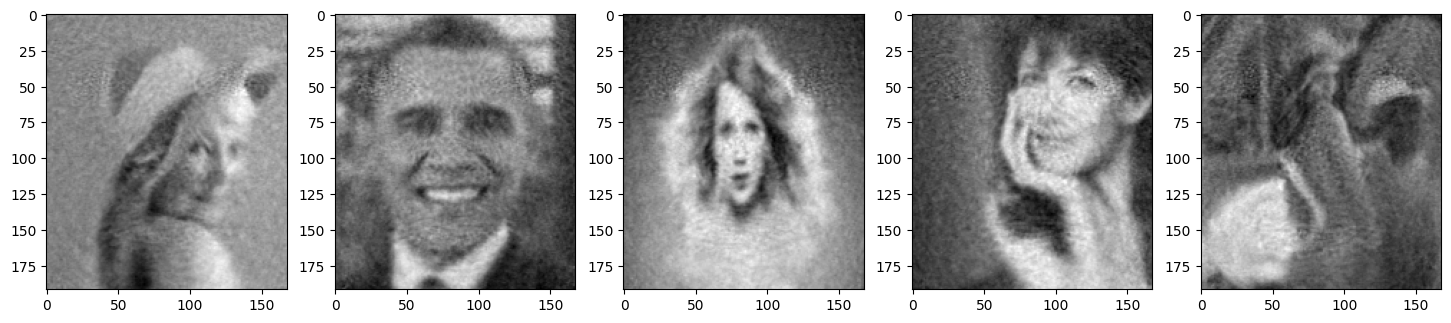

In [19]:
m, n, q = 168, 192, 2000

Xq = np.dot(U[:,0:q],df)

fig,ax=plt.subplots(1,5,figsize=(18,18))

for i in range(5):
    ax[i].imshow(Xq[:,i].reshape(m,n).T,cmap='gray')

(2) 自行找 5 張照片（大小必須同 Yale Faces 的 192×168 或自行 Resize），含人臉、水果、風景 … 等進行加密後（q 自選），再解密，觀察這些解密後的影像的效果，是否人臉的表現比較好？其他非人臉影像，如風景影像，能透過由人臉建構的特徵 U 加密嗎？（即解密後能否看到原圖模樣？）

先定義用來展示蒙太奇圖片的函數。

In [81]:
def show_montage(X, n, m, h, w): 
        '''
        X: 影像資料矩陣，每行代表一張影像
        n,m: 每張影像的大小 nxm
        h,w: 建立一個蒙太奇圖陣，大小 figsize=(w,h)
        '''
        fig, axes = plt.subplots(h, w, figsize=(3*w, 3*h)) 
        if X.shape[1]<w*h:# 影像張數不到 wxh 張，用 0 向量補齊
                X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
        for i, ax in enumerate(axes.flat):
                ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        plt.show()

匯入5張圖片，將 Yale Faces 資料做 SVD 後，幫這5張圖加密再解密。

C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\1553674135.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(D['m'])
C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\1553674135.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(D['n'])
C:\Users\f9006\AppData\Local\Temp\ipykernel_9276\1553674135.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_persons = int(D['person'])


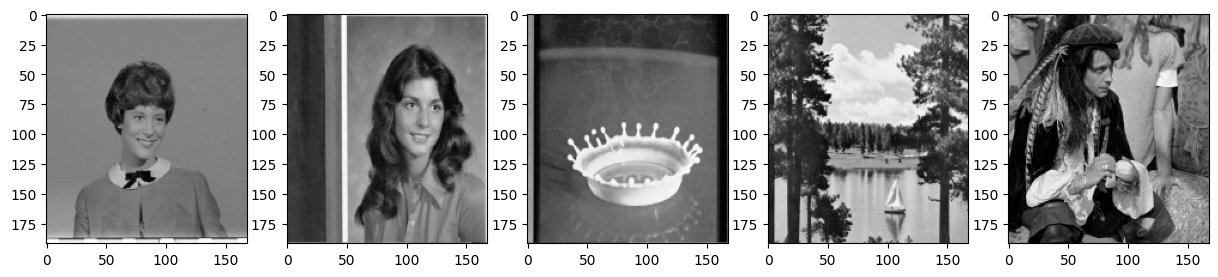

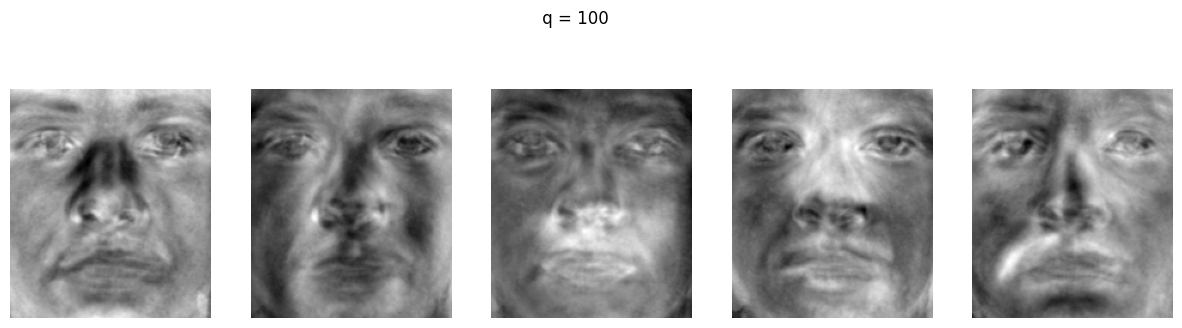

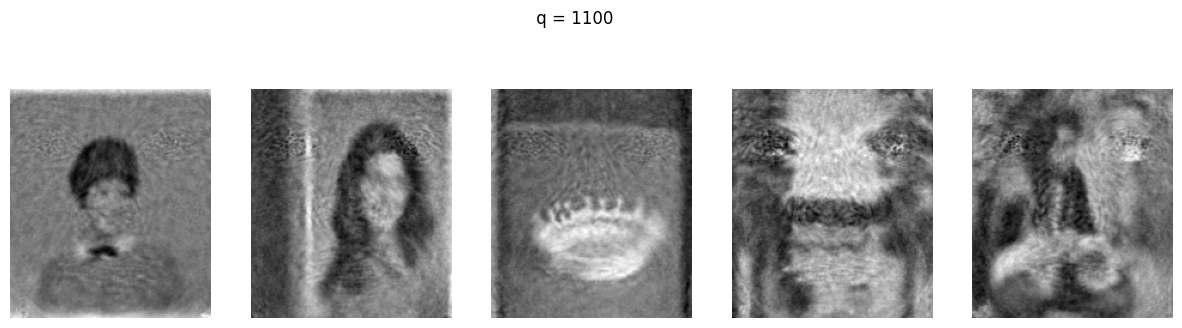

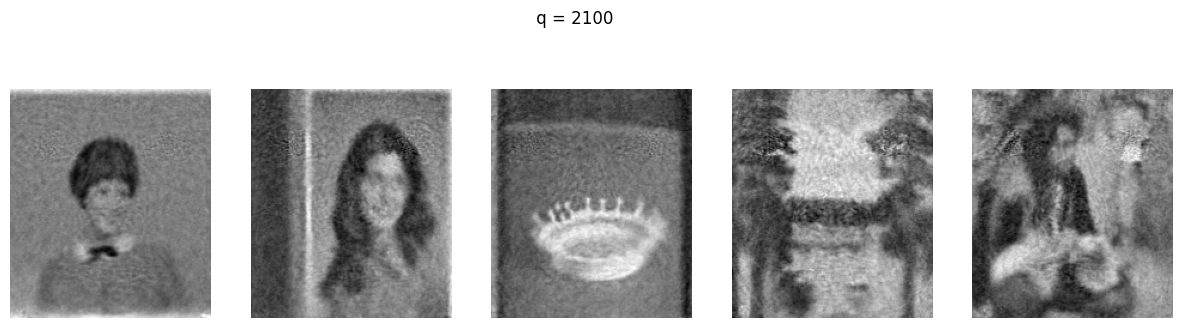

In [82]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.io
import pandas as pd
import matplotlib.image as mpimg
import PIL.Image as Image
from numpy.linalg import svd

# Load data
D = scipy.io.loadmat('allFaces.mat')
X = D['faces'] 
m = int(D['m'])
n = int(D['n']) 
n_persons = int(D['person']) 


# 圖列表名
img_names = ['4.1.03.jpg', 
             '4.1.04.jpg', 
             '4.2.01.jpg', 
             '4.2.06.jpg', 
             '5.3.02.jpg']

size = (168, 192)
flattened_images = []


# 逐一讀取每個圖像文件，調整大小，轉換為灰度圖像，並添加到列表中
for i in img_names:
    
    img = Image.open(i)
   
    img_resized = img.resize(size)
    
    img_gray = img_resized.convert('L')
   
    img_array = np.array(img_gray).T.flatten()
 
    flattened_images.append(img_array)

# 將列表轉換為矩陣
x_new = np.column_stack(flattened_images)
show_montage(x_new, n, m, 1,5)

avgFace = X.mean(axis = 1)
X_avg = X - avgFace.reshape(-1, 1)
U, E, VT = svd(X_avg, full_matrices=False)

for q in range(100, 2101, 1000):  
    Xq_n = U[:, :q] @ (U[:, :q].T @ x_new)
    plt.figure(figsize=(15, 4))  
    plt.suptitle(f' q = {q}')
    for i in range(Xq_n.shape[1]):  
            ax = plt.subplot(1, Xq_n.shape[1], i + 1)
            ax.imshow(Xq_n[:, i].reshape(168, 192).T, cmap='gray')
            ax.axis('off')
    plt.show()

**<font color=skyblue>對執行結果的觀察紀錄：</font>**  
- 由上述的執行成果可知，當 q 較小時 ( q = 100 )，這五張圖片的輪廓都不太清晰，都比較像 Yale Faces 資料。
- 當 q = 1000 ，人像確實比風景照更清楚。但第三張非人像的圖片也很清楚，推測是它不像風景照那麼複雜，且稍微有細節被模糊到就失真。
- 當 q = 2100 ，這五張圖片在肉眼觀察下感覺都有7成被還原出來。